## Homework 4

Use this notebook as a starter

In [235]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [236]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [237]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [238]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [239]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [240]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [241]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


## Your code

What are the categorical variables? What are the numerical?

In [242]:
categorical = ['home','marital', 'records','job']
numerical = ['seniority','time', 'age','expenses','income', 'assets','debt','amount','price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [244]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

# del df_train['default']
# del df_val['default']
# del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [245]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

rocauc_list = []
for x in ['seniority', 'time', 'income', 'debt']:
    rocauc = roc_auc_score(df_train['default'], df_train[x])
    if rocauc < 0.5:
        rocauc = roc_auc_score(df_train['default'], -df_train[x])
    print('roc_auc_score for {} : {}'.format(x,rocauc))
    rocauc_list.append((x,rocauc))
df_auc = pd.DataFrame(rocauc_list, columns=['variable','auc_score'])

# highest auc
df_auc[df_auc['auc_score'] == df_auc['auc_score'].max()]

roc_auc_score for seniority : 0.7093778624491943
roc_auc_score for time : 0.5608662489595051
roc_auc_score for income : 0.682006666132633
roc_auc_score for debt : 0.5047829675783548


,variable,auc_score
0,seniority,0.709378


Which numerical variable (among the following 4) has the highest AUC?

- **seniority**
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [246]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [247]:
round(roc_auc_score(y_val, y_pred),3)

0.811

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- **0.812**

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

<ipython-input-248-fdca00abf726>:16: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


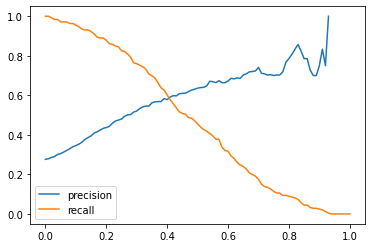

In [248]:
d = []
for i in np.linspace(0.0, 1.0, 101):
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    d.append((i,p,r))

columns = ['threshold', 'precision', 'recall']
df_rec_prec = pd.DataFrame(d, columns=columns)
    
plt.plot(df_rec_prec['threshold'], df_rec_prec['precision'], label='precision')
plt.plot(df_rec_prec['threshold'], df_rec_prec['recall'], label='recall')
plt.legend()

In [249]:
df_rec_prec[df_rec_prec.threshold.isin([0.00,0.20, 0.40, 0.6, 0.8])]

,threshold,precision,recall
0,0.0,0.276094,1.000000
20,0.2,0.437247,0.878049
40,0.4,0.578125,0.601626
60,0.6,0.672414,0.317073
80,0.8,0.785714,0.089431


At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [250]:
d = []
for i in np.linspace(0.0, 1.00, 101):
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2*p*r/(p+r)
    
    d.append((i,f1))

columns = ['threshold', 'f1']
df_f1 = pd.DataFrame(d, columns=columns)
df_f1[::10]

<ipython-input-250-57841c5d2721>:16: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


,threshold,f1
0,0.0,0.432718
10,0.1,0.507559
20,0.2,0.583784
30,0.3,0.618182
40,0.4,0.589641
50,0.5,0.530806
60,0.6,0.430939
70,0.7,0.282895
80,0.8,0.160584
90,0.9,0.047244


At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [251]:
def train(df_train, y_train, C):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

dv, model = train(df_train, y_train, C=1.0)

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

y_pred = predict(df_val, dv, model)

In [252]:
from sklearn.model_selection import KFold

In [253]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
#print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [254]:
from tqdm.auto import tqdm

In [255]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- **1**
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C